# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [55]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [56]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

### Variables

In [57]:
warnings.filterwarnings("ignore", category=FutureWarning)
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [58]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'RNMBY', 'SAABF', ..., 'BABA', 'WB', 'SYDB.CO'],
      dtype=object)

In [59]:
symbol = "ENG"
ticker = yf.Ticker(symbol)

earning_dates = ticker.cash_flow.columns.tolist()
display(earning_dates)

if len(earning_dates) == 5:
    earning_dates.remove(earning_dates[4])
    print(earning_dates)

cash_flow = ticker.cash_flow
display(cash_flow)

balance_sheet = ticker.balance_sheet
display(balance_sheet)

income_statement = ticker.income_stmt
display(income_statement)


[Timestamp('2023-12-31 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2020-12-31 00:00:00')]

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Free Cash Flow,-5005000.0,-15138000.0,-13904000.0,-947000.0
Repurchase Of Capital Stock,NaN,NaN,NaN,0.0
Repayment Of Debt,-1898000.0,-224000.0,-129000.0,-93000.0
Issuance Of Debt,1047000.0,625000.0,0.0,4949000.0
Issuance Of Capital Stock,2962000.0,0.0,19984000.0,0.0
Capital Expenditure,-174000.0,-602000.0,-240000.0,-428000.0
Interest Paid Supplemental Data,219000.0,223000.0,212000.0,153000.0
Income Tax Paid Supplemental Data,57000.0,52000.0,151000.0,86000.0
End Cash Position,615000.0,3464000.0,19202000.0,13706000.0
Beginning Cash Position,3464000.0,19202000.0,13706000.0,8307000.0


,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Ordinary Shares Number,5156583.0,4475077.0,4403834.0,3445085.0
Share Issued,5156583.0,4475077.0,4403834.0,3445085.0
Net Debt,432000.0,NaN,NaN,NaN
Total Debt,9345000.0,10727000.0,6436000.0,8589000.0
Tangible Book Value,-2275000.0,9605000.0,27471000.0,12903000.0
...,...,...,...,...
Notes Receivable,NaN,NaN,NaN,0.0
Accounts Receivable,10106000.0,9154000.0,8498000.0,6720000.0
Cash Cash Equivalents And Short Term Investments,615000.0,3464000.0,19202000.0,13706000.0
Cash And Cash Equivalents,615000.0,3464000.0,19202000.0,13706000.0


,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.21,0.21,0.27,0.27
Normalized EBITDA,-13897000.0,-17319000.0,-4852000.0,80000.0
Net Income From Continuing Operation Net Minority Interest,-15153000.0,-18514000.0,-5685000.0,-625000.0
Reconciled Depreciation,933000.0,933000.0,561000.0,449000.0
Reconciled Cost Of Revenue,39402000.0,44401000.0,37053000.0,55998000.0
EBITDA,-13897000.0,-17319000.0,-4852000.0,80000.0
EBIT,-14830000.0,-18252000.0,-5413000.0,-369000.0
Net Interest Income,-219000.0,-223000.0,-212000.0,-153000.0
Interest Expense,219000.0,223000.0,212000.0,153000.0


#### Download annual financial data

In [ ]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
                    print(error)
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [61]:
if debugging:
    display(df)

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers
0,MATAS.CO,2025-03-31,NaN,NaN,NaN,Consumer Cyclical,Specialty Retail,-3.060000e+08,0.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATAS.CO,2024-03-31,0.006267,0.065357,0.159205,Consumer Cyclical,Specialty Retail,2.390000e+08,-21000000.0,-1.890000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MATAS.CO,2023-03-31,0.014033,0.205079,0.459568,Consumer Cyclical,Specialty Retail,4.240000e+08,0.0,-1.260000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MATAS.CO,2022-03-31,-0.211179,-0.301726,-0.110513,Consumer Cyclical,Specialty Retail,3.271000e+08,-75100000.0,-7.084000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RNMBY,2025-03-31,NaN,NaN,NaN,Industrials,Aerospace & Defense,2.670000e+08,NaN,-4.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,Z,2021-12-31,-0.233673,-0.472670,-0.495536,Communication Services,Internet Content & Information,-3.282000e+09,-302000000.0,-1.978000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5752,ZBRA,2025-03-31,NaN,NaN,NaN,Technology,Communication Equipment,1.580000e+08,-125000000.0,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5753,ZBRA,2023-12-31,0.094752,0.114908,0.441257,Technology,Communication Equipment,-9.100000e+07,-52000000.0,-2.450000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5754,ZBRA,2022-12-31,0.240201,0.153738,0.065988,Technology,Communication Equipment,4.130000e+08,-751000000.0,-2.470000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [62]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [63]:
pred_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    train_data = pd.concat([train_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print('Train and Test Data:')
    display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers
0,822,2025-03-31,NaN,NaN,NaN,2,124,-0.029287,0.092877,0.037622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1131,2025-03-31,NaN,NaN,NaN,7,1,-0.028525,0.000000,0.037186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1148,2025-03-31,NaN,NaN,NaN,7,1,-0.029153,0.074748,0.037622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,947,2025-03-31,NaN,NaN,NaN,7,1,-0.026905,0.051560,0.037038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,577,2025-03-31,NaN,NaN,NaN,6,17,-0.028539,0.092877,0.037620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,1428,2025-03-31,NaN,NaN,NaN,6,17,-0.028878,0.092796,0.037617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5740,1430,2025-03-31,NaN,NaN,NaN,6,78,-0.028896,0.060943,0.037380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5744,1434,2025-03-31,NaN,NaN,NaN,11,140,-0.028885,0.000000,0.037616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5748,1437,2025-03-31,NaN,NaN,NaN,1,68,-0.028934,0.056031,0.036011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers
1,822,2024-03-31,0.006267,0.065357,0.159205,2,124,-0.028563,0.089781,0.037455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,822,2023-03-31,0.014033,0.205079,0.459568,2,124,-0.028317,0.092877,0.037510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,822,2022-03-31,-0.211179,-0.301726,-0.110513,2,124,-0.028446,0.081808,0.036996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1131,2023-12-31,0.768973,0.616452,1.071535,7,1,-0.028422,0.000000,0.037194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1131,2022-12-31,0.493045,0.398488,0.633525,7,1,-0.029113,0.000000,0.037417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,1437,2022-12-31,0.380627,0.560385,0.796337,1,68,-0.023078,-0.046696,0.034585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5751,1437,2021-12-31,-0.233673,-0.472670,-0.495536,1,68,-0.033244,0.048367,0.035876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5753,1438,2023-12-31,0.094752,0.114908,0.441257,9,25,-0.029001,0.085213,0.037405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5754,1438,2022-12-31,0.240201,0.153738,0.065988,9,25,-0.028331,-0.017809,0.037404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Labeling

In [64]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    display(X_train)
    display(y_train)
    display(X_test)
    display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,...,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers
4367,704,7,1,-0.028875,0.000000,0.037622,-0.039933,-7.228605e-18,0.038362,-0.043666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,459,6,76,-0.028882,0.000000,0.037622,-0.039933,-7.228605e-18,0.038363,-0.043675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3506,277,0,122,-0.029460,0.092228,0.035589,-0.037863,-7.228605e-18,0.037731,-0.043637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3697,379,9,25,-0.028837,0.000000,0.037590,-0.039933,-3.769698e-02,0.038358,-0.043641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2482,1172,6,75,-0.028755,0.064059,0.036844,-0.038759,-3.769698e-02,0.038138,-0.043569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,759,1,127,-0.028893,0.092841,0.037622,-0.039933,-7.228605e-18,0.038349,-0.043663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,163,2,92,-0.028661,0.092877,0.037178,-0.039521,-3.769698e-02,0.038256,-0.043578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,440,7,39,-0.028431,0.092877,0.037426,-0.039933,-3.769698e-02,0.038296,-0.043432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1703,812,0,122,-0.021254,0.024638,0.034157,-0.039933,-7.228605e-18,0.036054,-0.042066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
4367,-0.065527,0.148148,0.287892
3814,-0.307692,-0.384615,0.923077
3506,0.029621,-0.060427,0.058649
3697,-0.029656,0.154792,-0.032911
2482,0.041079,0.288940,-0.039668
...,...,...,...
4453,-0.032258,-0.066414,0.017078
425,0.185030,0.117081,0.158582
1021,-0.000936,-0.070204,-0.021248
1703,0.133289,0.017762,-0.009804


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,End Cash Position,...,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers
2298,1089,2,6,-0.029214,0.031182,0.037187,-0.039466,-7.228605e-18,3.802092e-02,-0.043075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1543,732,7,74,-0.028583,0.092877,0.037569,-0.039933,-7.228605e-18,3.824728e-02,-0.043638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5273,1205,5,32,-0.029073,0.041253,0.036603,-0.038770,-7.228605e-18,4.495390e-18,-0.038990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2646,1261,3,14,-0.026592,-0.378781,0.035715,-0.036505,-7.228605e-18,3.714263e-02,-0.043530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5115,1121,2,112,-0.028843,0.092612,0.037578,-0.039894,-7.228605e-18,3.834686e-02,-0.043637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,1153,0,2,-0.028907,0.092877,0.037620,-0.039929,-3.769649e-02,3.836177e-02,-0.043672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3269,160,9,40,-0.028753,0.092861,0.037586,-0.039928,-7.228605e-18,3.834849e-02,-0.043578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4225,649,7,125,-0.028934,0.092743,0.037622,-0.039933,-7.228605e-18,3.834695e-02,-0.043226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975,932,8,99,-0.025505,0.092877,0.035361,-0.034228,-3.560415e-02,3.772861e-02,-0.042213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
2298,-0.063963,-0.015957,0.381306
1543,0.192528,0.022720,0.082969
5273,0.148650,0.174545,0.201957
2646,0.063865,0.176377,0.120787
5115,0.131807,-0.101561,-0.046829
...,...,...,...
5157,-0.081967,-0.426230,-0.704918
3269,-0.104831,-0.044327,0.256681
4225,0.147882,0.071345,0.539837
1975,-0.069639,-0.169257,-0.214102


## Model Training

In [65]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        n_iter_no_change=10
    )
    model.fit(X_train, y_train)

Iteration 1, loss = 504.67434005
Validation score: -25.073149
Iteration 2, loss = 10.36222431
Validation score: -23.014366
Iteration 3, loss = 9.51991424
Validation score: -13.402566
Iteration 4, loss = 9.24709612
Validation score: -0.120282
Iteration 5, loss = 9.20018347
Validation score: -5.265287
Iteration 6, loss = 9.36053364
Validation score: -5.530407
Iteration 7, loss = 9.46020760
Validation score: -1.498380
Iteration 8, loss = 9.62995650
Validation score: -2.589711
Iteration 9, loss = 9.55470008
Validation score: -7.319292
Iteration 10, loss = 9.25856946
Validation score: -2.320463
Iteration 11, loss = 9.18056571
Validation score: -0.560246
Iteration 12, loss = 9.16965288
Validation score: -0.171788
Iteration 13, loss = 9.18976929
Validation score: -0.421432
Iteration 14, loss = 9.19209779
Validation score: -0.697411
Iteration 15, loss = 9.21917135
Validation score: -0.421150
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


## Testing and benchmarking

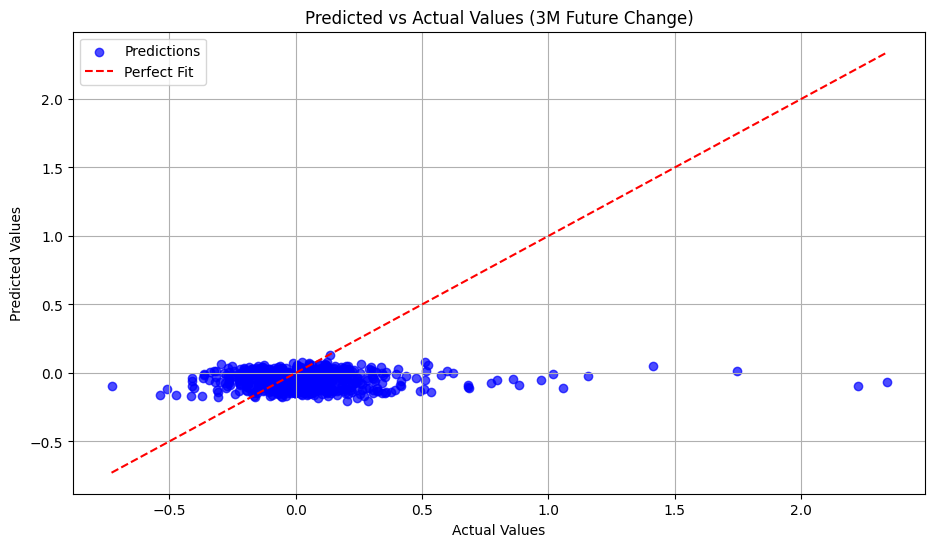

3M Future Change - R²: -0.1845
3M Future Change - MSE: 0.0785
3M Future Change - MAE: 0.1795


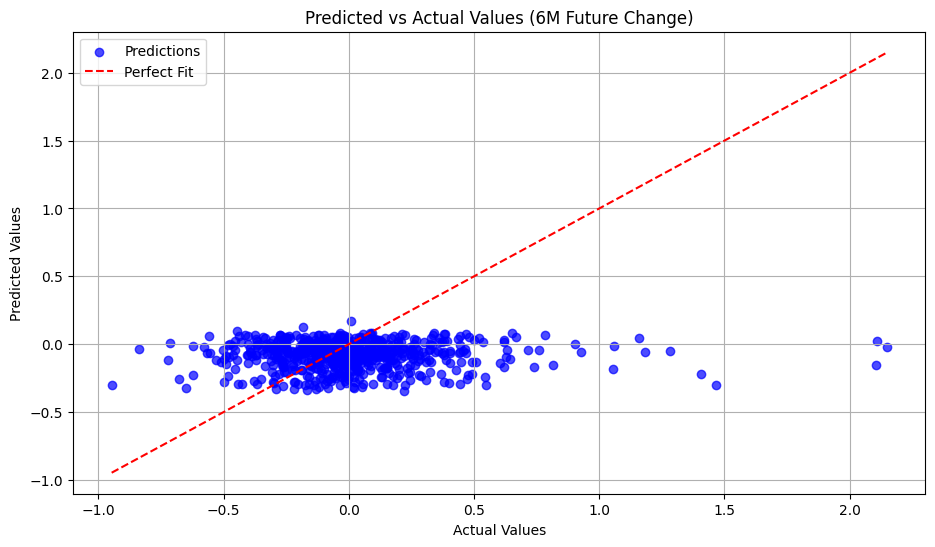

6M Future Change - R²: -0.1481
6M Future Change - MSE: 0.1217
6M Future Change - MAE: 0.2410


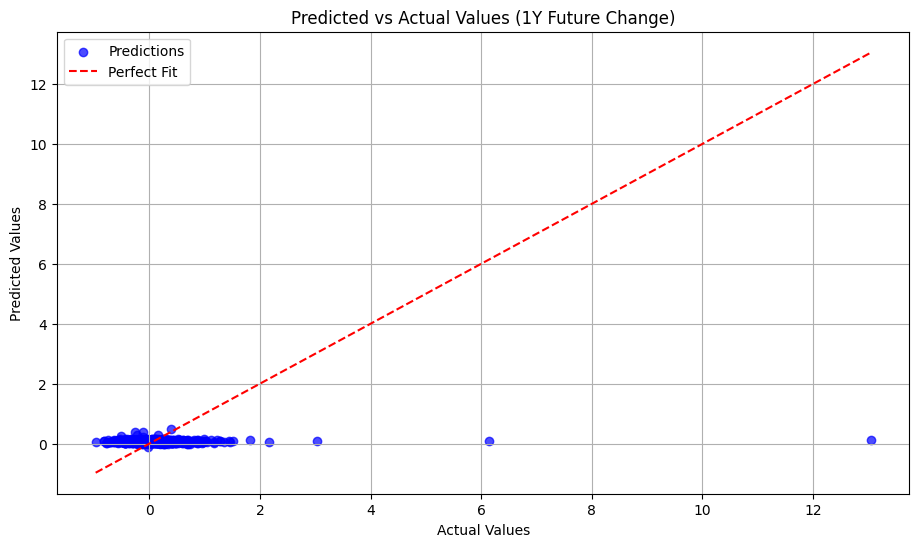

1Y Future Change - R²: -0.0025
1Y Future Change - MSE: 0.4890
1Y Future Change - MAE: 0.3341

Overall Scores:
Mean - R²: -0.1117
Mean - MSE: 0.2297
Mean - MAE: 0.2515


In [66]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [69]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

Old best R²: -1.775213422200237
New best R²: -0.11171634963871213
Saving new best model...


## Predictions on latest data

In [70]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.1117163496387121


In [72]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,mean (%),3m (%),6m (%),1y (%)
0,MATAS.CO,3.564634,-3.584288,3.234804,11.043386
1,RNMBY,-11.948308,-12.910528,-28.728573,5.794178
2,SAABF,-12.458871,-13.837617,-29.085843,5.546847
3,NSKFF,-10.381465,-10.722550,-24.610076,4.188233
4,GMAB,-4.642856,-4.051884,-12.827503,2.950820
...,...,...,...,...,...
1434,XOMA,-13.934403,-17.255241,-32.275203,7.727234
1435,XRAY,-6.926343,-15.108512,-17.631472,11.960957
1436,YORW,-1.412378,-14.192136,-5.541123,15.496123
1437,Z,-8.558643,-15.830336,-20.512726,10.667133


In [73]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [74]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://649c32b2904cefe078.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
